# Olympic Data Analysis and Predictive Machine Learning

This Notebook is exploring a dataset of Olympic data (Sourced from [The Guardian - Kaggle](https://www.kaggle.com/datasets/the-guardian/olympic-games)) and aims to first Explore the data and then build a predictive model to determine if it is possible to predict the results of a future Olympic event using past data.

## Import Libraries

In [1]:
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import count
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Data Loading and Preparation

In [2]:
def DataLoader(dataDirectory):
    dictPath = dataDirectory + "dictionary.csv"
    summerPath = dataDirectory + "summer.csv"
    winterPath = dataDirectory + "winter.csv"

    olympicDict = pd.read_csv(dictPath)
    summerData = pd.read_csv(summerPath)
    winterData = pd.read_csv(winterPath)

    return olympicDict, summerData, winterData

olympicDict, summerData, winterData = DataLoader("Data/")

In [14]:
def findUndefinedCountries(data, dictionary):
    undefinedCountries = data[~data["Country"].isin(dictionary["Code"])]
    return undefinedCountries["Country"].drop_duplicates().reset_index(drop=True)

summerUndefinedCountries = findUndefinedCountries(summerData, olympicDict)
winterUndefinedCountries = findUndefinedCountries(winterData, olympicDict)

undefinedCountries = pd.concat([summerUndefinedCountries, winterUndefinedCountries]).drop_duplicates().reset_index(drop=True)
display(undefinedCountries)


Series([], Name: Country, dtype: object)

19 Country codes are included in the data that do not exist in the dictionary. There are several reasons that this may have occured, and can be fixed. 
For Example, athletes from `URS` represented the Soviet Union at relevant Olympics

In [4]:
for country in undefinedCountries:
    display(summerData[summerData["Country"] == country][["Year","Sport","Athlete","Country","Gender","Event","Medal"]].head(5))

,Year,Sport,Athlete,Country,Gender,Event,Medal
132,1896,Tennis,"FLACK, Edwin",ZZX,Men,Doubles,Bronze
133,1896,Tennis,"ROBERTSON, George Stuart",ZZX,Men,Doubles,Bronze
134,1896,Tennis,"BOLAND, John",ZZX,Men,Doubles,Gold
135,1896,Tennis,"TRAUN, Friedrich",ZZX,Men,Doubles,Gold
136,1896,Tennis,"KASDAGLIS, Dionysios",ZZX,Men,Doubles,Silver


,Year,Sport,Athlete,Country,Gender,Event,Medal
275,1900,Athletics,"JANDA, Frantisek",BOH,Men,Discus Throw,Silver
648,1900,Tennis,"ROSENBAUM, Hedwig",BOH,Women,Singles,Bronze
1345,1908,Fencing,"GOPPOLD DE LOBSDORF, Vilem",BOH,Men,Sabre Individual,Bronze
1348,1908,Fencing,"GOPPOLD DE LOBSDORF, Vilem",BOH,Men,Sabre Team,Bronze
1349,1908,Fencing,"LADA, Vlastimil",BOH,Men,Sabre Team,Bronze


,Year,Sport,Athlete,Country,Gender,Event,Medal
1146,1908,Aquatics,"BEAUREPAIRE, Frank E.",ANZ,Men,1500M Freestyle,Bronze
1154,1908,Aquatics,"BEAUREPAIRE, Frank E.",ANZ,Men,400M Freestyle,Silver
1208,1908,Athletics,"KERR, Harry E.",ANZ,Men,3500M Walk,Bronze
1298,1908,Boxing,"BAKER, Reginald L.",ANZ,Men,63.5 - 71.67KG (Middleweight),Silver
1648,1908,Rugby,"BARNETT, Jumbo",ANZ,Men,Rugby,Gold


,Year,Sport,Athlete,Country,Gender,Event,Medal
1852,1908,Skating,"PANIN, Nikolay",RU1,Men,Special Figures,Gold
1927,1908,Wrestling,"ORLOFF, Nikolaï",RU1,Men,- 66.6KG (Lightweight),Silver
1930,1908,Wrestling,"PETROFF, Aleksander",RU1,Men,+ 93KG (Super Heavyweight),Silver
2535,1912,Rowing,"KUSIK, Mikhaïl Maksimilian",RU1,Men,Single Sculls (1X),Bronze
2538,1912,Sailing,"Beloselsky-Belozersky, Esper Konstantinovich",RU1,Men,10M,Bronze


,Year,Sport,Athlete,Country,Gender,Event,Medal
3577,1920,Ice Hockey,"DUSEK, Adolf",TCH,Men,Ice Hockey,Bronze
3578,1920,Ice Hockey,"HARTMANN, Karel",TCH,Men,Ice Hockey,Bronze
3579,1920,Ice Hockey,"LOOS, Vilém",TCH,Men,Ice Hockey,Bronze
3580,1920,Ice Hockey,"PALOUS, Jan",TCH,Men,Ice Hockey,Bronze
3581,1920,Ice Hockey,"PEKA, Jan",TCH,Men,Ice Hockey,Bronze


,Year,Sport,Athlete,Country,Gender,Event,Medal
4587,1924,Gymnastics,"STUKELJ, Leon",YUG,Men,Horizontal Bar,Gold
4590,1924,Gymnastics,"STUKELJ, Leon",YUG,Men,Individual All-Round,Gold
5415,1928,Gymnastics,"STUKELJ, Leon",YUG,Men,Individual All-Round,Bronze
5420,1928,Gymnastics,"PRIMOZIC, Josip",YUG,Men,Parallel Bars,Silver
5425,1928,Gymnastics,"STUKELJ, Leon",YUG,Men,Rings,Gold


,Year,Sport,Athlete,Country,Gender,Event,Medal
4730,1924,Rugby,"ANASTASIADE, N.",ROU,Men,Rugby,Bronze
4731,1924,Rugby,"ARMASEL, Dumitru",ROU,Men,Rugby,Bronze
4732,1924,Rugby,"BENTIA, Gheorghe",ROU,Men,Rugby,Bronze
4733,1924,Rugby,"COCIOCIAHO, J.",ROU,Men,Rugby,Bronze
4734,1924,Rugby,"CRATUNESCO, C.",ROU,Men,Rugby,Bronze


,Year,Sport,Athlete,Country,Gender,Event,Medal
8114,1952,Athletics,"ANUFRIYEV, Aleksandr",URS,Men,10000M,Bronze
8117,1952,Athletics,"JUNK, Bruno",URS,Men,10000M Walk,Bronze
8135,1952,Athletics,"KHNYKINA-DVALISHVILI, Nadezhda",URS,Women,200M,Bronze
8140,1952,Athletics,"KAZANTSEV, Vladimir",URS,Men,3000M Steeplechase,Silver
8146,1952,Athletics,"LITUEV, Yuri",URS,Men,400M Hurdles,Silver


,Year,Sport,Athlete,Country,Gender,Event,Medal
8940,1956,Aquatics,"TEN ELSEN, Eva-Maria",EUA,Women,200M Breaststroke,Bronze
8941,1956,Aquatics,"HAPPE-KREY, Ursula",EUA,Women,200M Breaststroke,Gold
9013,1956,Athletics,"STUBNICK, Christa",EUA,Women,100M,Silver
9019,1956,Athletics,"RICHTZENHAIN, Klaus",EUA,Men,1500M,Silver
9025,1956,Athletics,"STUBNICK, Christa",EUA,Women,200M,Silver


,Year,Sport,Athlete,Country,Gender,Event,Medal
9977,1960,Athletics,"GARDNER, Keith Alvin Saint",BWI,Men,4X400M Relay,Bronze
9978,1960,Athletics,"KERR, George Ezekiel",BWI,Men,4X400M Relay,Bronze
9979,1960,Athletics,"SPENCE, Malcolm A.E.",BWI,Men,4X400M Relay,Bronze
9980,1960,Athletics,"WEDDERBURN, James",BWI,Men,4X400M Relay,Bronze
9995,1960,Athletics,"KERR, George Ezekiel",BWI,Men,800M,Bronze


,Year,Sport,Athlete,Country,Gender,Event,Medal
11697,1968,Aquatics,"MATTHES, Roland",GDR,Men,100M Backstroke,Gold
11724,1968,Aquatics,"MATTHES, Roland",GDR,Men,200M Backstroke,Gold
11740,1968,Aquatics,"LINDNER, Helga",GDR,Women,200M Butterfly,Silver
11762,1968,Aquatics,"STEINBACH, Sabine",GDR,Women,400M Individual Medley,Bronze
11785,1968,Aquatics,"KRAUSE, Roswitha",GDR,Women,4X100M Freestyle Relay,Silver


,Year,Sport,Athlete,Country,Gender,Event,Medal
11759,1968,Aquatics,"HOLTHAUS, Michael",FRG,Men,400M Individual Medley,Bronze
11801,1968,Aquatics,"FROMMATER, Uta",FRG,Women,4X100M Medley Relay,Bronze
11802,1968,Aquatics,"HUSTEDE-NAGEL, Heike",FRG,Women,4X100M Medley Relay,Bronze
11803,1968,Aquatics,"KRAUS, Angelika",FRG,Women,4X100M Medley Relay,Bronze
11804,1968,Aquatics,"REINECK, Heidemarie",FRG,Women,4X100M Medley Relay,Bronze


,Year,Sport,Athlete,Country,Gender,Event,Medal
19602,1992,Aquatics,"MIROCHINA, Elena",EUN,Women,10M Platform,Silver
19603,1992,Aquatics,"SAUTIN, Dmitry",EUN,Men,3M Springboard,Bronze
19608,1992,Aquatics,"LACHKO, Irina",EUN,Women,3M Springboard,Silver
19619,1992,Aquatics,"RUDKOVSKAYA, Elena",EUN,Women,100M Breaststroke,Gold
19628,1992,Aquatics,"POPOV, Alexander",EUN,Men,100M Freestyle,Gold


,Year,Sport,Athlete,Country,Gender,Event,Medal
21056,1992,Shooting,"SEKARIC, Jasna",IOP,Women,10M Air Pistol (40 Shots),Silver
21060,1992,Shooting,"BINDER, Aranka",IOP,Women,10M Air Rifle (40 Shots),Bronze
21081,1992,Shooting,"PLETIKOSIC, Stevan",IOP,Men,50M Rifle Prone (60 Shots),Bronze


,Year,Sport,Athlete,Country,Gender,Event,Medal
27225,2008,Aquatics,"CAVIC, Milorad",SRB,Men,100M Butterfly,Silver
27443,2008,Aquatics,"CIRIC, Aleksandar",SRB,Men,Water Polo,Bronze
27444,2008,Aquatics,"FILIPOVIC, Filip",SRB,Men,Water Polo,Bronze
27445,2008,Aquatics,"GOCIC, Zivko",SRB,Men,Water Polo,Bronze
27446,2008,Aquatics,"PEKOVIC, Branko",SRB,Men,Water Polo,Bronze


,Year,Sport,Athlete,Country,Gender,Event,Medal


,Year,Sport,Athlete,Country,Gender,Event,Medal
29626,2012,Athletics,"GORDON, Lalonde",TTO,Men,400M,Bronze
29641,2012,Athletics,"BLEDMAN, Keston",TTO,Men,4X100M Relay,Silver
29642,2012,Athletics,"BURNS, Marc",TTO,Men,4X100M Relay,Silver
29643,2012,Athletics,"CALLENDER, Emmanuel",TTO,Men,4X100M Relay,Silver
29644,2012,Athletics,"THOMPSON, Richard",TTO,Men,4X100M Relay,Silver


,Year,Sport,Athlete,Country,Gender,Event,Medal
30454,2012,Handball,"BARJAKTAROVIC, Sonja",MNE,Women,Handball,Silver
30455,2012,Handball,"BULATOVIC, Andela",MNE,Women,Handball,Silver
30456,2012,Handball,"BULATOVIC, Katarina",MNE,Women,Handball,Silver
30457,2012,Handball,"DOKIC, Ana",MNE,Women,Handball,Silver
30458,2012,Handball,"JOVANOVIC, Marija",MNE,Women,Handball,Silver


,Year,Sport,Athlete,Country,Gender,Event,Medal
30883,2012,Table Tennis,"FENG, Tian Wei",SGP,Women,Singles,Bronze
30899,2012,Table Tennis,"FENG, Tian Wei",SGP,Women,Team,Bronze
30900,2012,Table Tennis,"LI, Jia Wei",SGP,Women,Team,Bronze
30901,2012,Table Tennis,"WANG, Yuegu",SGP,Women,Team,Bronze


Using the athletes above and some online searching the country they competed for can be determined. Subsequently, The Country can be correctly allocated according to the dictionary, or, where a valid country exists, the country added to the dictionary.

| Initial Country Code | Country                                | Correct Country Code   | Action Taken        |
|----------------------|----------------------------------------|------------------------|---------------------|
| ZZX                  | Mixed Countries                        | ZZX                    | Update Dictionary   |
| BOH                  | Bohemia                                | BOH                    | Update Dictionary   |
| ANZ                  | Australasia (Australia and NewZealand) | ANZ                    | Update Dictionary   |
| RU1                  | Russian Empire                         | RUS                    | Update Dataset      |
| TCH                  | Czechoslovakia                         | TCH                    | Update Dictionary   |
| YUG                  | Yugoslavia                             | YUG                    | Update Dictionary   |
| ROU                  | Romaina                                | ROM                    | Update Dataset      |
| URS                  | Soviet Union                           | RUS                    | Update Dataset      |
| EUA                  | United Team of Germany                 | GER                    | Update Dataset      |
| BWI                  | British West Indies (1960)             | BWI                    | Remove From Dataset |
| GDR                  | East Germany                           | GER                    | Update Dataset      |
| FRG                  | West Germany                           | GER                    | Update Dataset      |
| EUN                  | Unified Team (Former Soviet Countries) | RUS                    | Update Dataset      |
| IOP                  | Independent Olympic Participants       | YUG (1992), IND (2014) | Update Dataset      |
| SRB                  | Serbia                                 | SCG                    | Update Dataset      |
| TTO                  | Trinidad and Tobago                    | TRI                    | Update Dataset      |
| MNE                  | Montenegro                             | MNE                    | Update Dictionary   |
| SGP                  | Singapore                              | SIN                    | Update Dataset      |
| IOP                  | Independent Olympic Participants       | YUG                    | Update Dataset      |


In [13]:
import pandas as pd

def dataCleanup(data):
    # Remove rows with "Pending" athletes
    data = data[data["Athlete"] != "Pending"]

    # Fill missing countries with "RUS"
    data["Country"].fillna("RUS", inplace=True)

    # Replace specific country codes in data
    data.loc[data["Country"] == "RU1", "Country"] = "RUS"
    data.loc[data["Country"] == "ROU", "Country"] = "ROM"
    data.loc[data["Country"] == "URS", "Country"] = "RUS"
    data.loc[data["Country"] == "EUA", "Country"] = "GER"
    data.loc[data["Country"] == "GDR", "Country"] = "GER"
    data.loc[data["Country"] == "FRG", "Country"] = "GER"
    data.loc[data["Country"] == "EUN", "Country"] = "RUS"
    data.loc[(data["Country"] == "IOP") & (data["Year"] == "1992"), "Country"] = "YUG"
    data.loc[(data["Country"] == "IOP") & (data["Year"] == "2014"), "Country"] = "IND"
    data.loc[data["Country"] == "SRB", "Country"] = "SCG"
    data.loc[data["Country"] == "TTO", "Country"] = "TRI"
    data.loc[data["Country"] == "SGP", "Country"] = "SIN"
    data.loc[data["Country"] == "IOP", "Country"] = "YUG"

    # Drop rows with "BWI" country code
    data.drop(data[data["Country"] == "BWI"].index, inplace=True)
    return data

def dictionaryCleanup(dictionary):
        # Add missing entries to dictionary
    new_entries = [
        ["Mixed Countries", "ZZX", "", ""],
        ["Bohemia", "BOH", "", ""],
        ["Australasia (Australia and NewZealand)", "ANZ", "", ""],
        ["Czechoslovakia", "TCH", "", ""],
        ["Yugoslavia", "YUG", "", ""],
        ["Montenegro", "MNE", "", ""]
    ]
    dictionary = pd.concat([pd.DataFrame(new_entries, columns=dictionary.columns), dictionary], ignore_index=True)
    # Sort and reset index of dictionary
    dictionary = dictionary.sort_values("Code").reset_index(drop=True)

    return dictionary

summerData = dataCleanup(summerData)
winterData = dataCleanup(winterData)

olympicDict = dictionaryCleanup(olympicDict)

/tmp/ipykernel_3002017/2496735287.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Country"].fillna("RUS", inplace=True)
/tmp/ipykernel_3002017/2496735287.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [15]:
def dataAggregation(data):
    # Medal values are being defined in a way that higher = better. This will make it easier for analysis later.
    medalCountDict = {"Bronze" : 1, "Silver" : 2, "Gold" : 3}
    # Map the numerical values of the medals based on the string defined in the dictionary above.
    data["MedalVal"] = data["Medal"].map(medalCountDict)

    # Select only necessary data
    data = data[["Year", "Sport", "Country", "Medal", "MedalVal"]] #  "Discipline", "Event", could also be included if desired

    # Group data each Olympics, each Country, for each sport, and count the total number of medals (higher is better).
    medalCounts = data.groupby(["Year", "Country", "Sport"])["MedalVal"].sum().reset_index()

    # Create a DataFrame with all unique combinations of Year, Country, and Sport
    # This ensures all possible combinations are represented
    years = data['Year'].unique()
    countries = data['Country'].unique()
    sports = data['Sport'].unique()
    
    index = pd.MultiIndex.from_product([years, countries, sports], names=['Year', 'Country', 'Sport'])
    full_index_df = pd.DataFrame(index=index).reset_index()
    
    # Merge full_index_df with medalCounts to include all combinations and fill missing with 0
    medalCounts = full_index_df.merge(medalCounts, on=['Year', 'Country', 'Sport'], how='left')
    medalCounts['MedalVal'].fillna(0, inplace=True)


    # Calculate each countries Total Number of medals at each Olympics
    overallResults = medalCounts.groupby(["Year", "Country"])["MedalVal"].sum().reset_index()
    
    # Create a Rank Based on this number
    overallResults["Rank"] = overallResults.groupby("Year")["MedalVal"].rank(ascending = False, method = "min").astype(int)

    # Reorder the rows to make the data easier to read / use
    overallResults = overallResults.sort_values(by = ["Year", "Rank"]).reset_index(drop=True)


    return medalCounts, overallResults

summerMedalCounts, summerOverallResults = dataAggregation(summerData)
winterMedalCounts, winterOverallResults = dataAggregation(winterData)

/tmp/ipykernel_3002017/3289284023.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  medalCounts['MedalVal'].fillna(0, inplace=True)
/tmp/ipykernel_3002017/3289284023.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

## Data Exploration

In [7]:
summerMedalCounts.head
summerOverallResults.head

<bound method NDFrame.head of       Year Country  MedalVal  Rank
0     1896     GRE      92.0     1
1     1896     GER      90.0     2
2     1896     USA      49.0     3
3     1896     FRA      25.0     4
4     1896     GBR      14.0     5
...    ...     ...       ...   ...
3694  2012     VIE       0.0    86
3695  2012     YUG       0.0    86
3696  2012     ZAM       0.0    86
3697  2012     ZIM       0.0    86
3698  2012     ZZX       0.0    86

[3699 rows x 4 columns]>

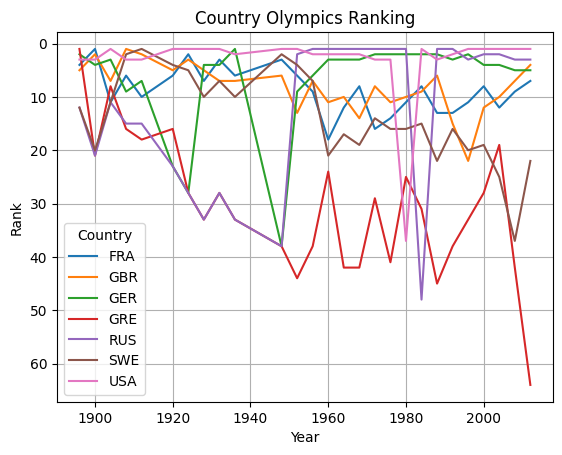

In [8]:
def plotCountryRankingsOverTime(data, positionThreshold):
    # Group by countries
    countryGroupedData = data.groupby("Country").filter(lambda country: country["Rank"].min() <= positionThreshold)
    countryGroupedData = countryGroupedData.groupby("Country")
    # Create a line for each country
    for name, group in countryGroupedData:
        plt.plot(group["Year"], group["Rank"], label = name)

    plt.title("Country Olympics Ranking")
    plt.xlabel("Year")
    plt.ylabel("Rank")
    plt.gca().invert_yaxis() # Invert the Y-Axis to show rank 1 at the top
    plt.legend(title = "Country")
    plt.grid(True)

    plt.show()
    

plotCountryRankingsOverTime(summerOverallResults, 1)

In [ ]:
# MORE EDA

In [16]:
# Animated Graph??

## Machine Learning

In [10]:
# target = Overall Ranking
# Features (For one year - for 3 sports) = Points per sport  
output = {}

for sport in summerMedalCounts["Sport"].unique():
    MLData = summerMedalCounts[["Year", "Country", "Sport", "MedalVal"]]
    MLData = MLData[MLData["Sport"] == sport].reset_index(drop=True)
    
    MLYVal = summerOverallResults[["Year", "Country", "Rank"]].reset_index(drop=True)
    
    MLData = MLData.merge(MLYVal, on=["Year","Country"], how = "inner")
    
    MLData.head()
    
    e = MLData[["Country","MedalVal"]]
    
    labelEnc = OneHotEncoder(handle_unknown='ignore')
    
    labelEnc.fit(e[["Country"]])
    
    X = pd.DataFrame(labelEnc.transform(e[["Country"]]).toarray())
    X["MedalVal"] = e["MedalVal"]

    X = X.to_numpy()


    # For each sport, can the overall performance of a country be determined based on their number of medals in 
    X2ElectricBoogaloo = e["MedalVal"].to_numpy().reshape(-1,1)
    
    y = MLData["Rank"]
    
    reg = LinearRegression().fit(X2ElectricBoogaloo, y)
    
    reg.score(X2ElectricBoogaloo, y)

    output[sport] = reg.score(X2ElectricBoogaloo,y)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 [Text(0, 0, 'Croquet'),
  Text(1, 0, 'Roque'),
  Text(2, 0, 'Rackets'),
  Text(3, 0, 'Basque Pelota'),
  Text(4, 0, 'Water Motorsports'),
  Text(5, 0, 'Golf'),
  Text(6, 0, 'Ice Hockey'),
  Text(7, 0, 'Cricket'),
  Text(8, 0, 'Jeu de paume'),
  Text(9, 0, 'Triathlon'),
  Text(10, 0, 'Canoe'),
  Text(11, 0, 'Lacrosse'),
  Text(12, 0, 'Skating'),
  Text(13, 0, 'Polo'),
  Text(14, 0, 'Tug of War'),
  Text(15, 0, 'Badminton'),
  Text(16, 0, 'Taekwondo'),
  Text(17, 0, 'Rugby'),
  Text(18, 0, 'Baseball'),
  Text(19, 0, 'Softball'),
  Text(20, 0, 'Table Tennis'),
  Text(21, 0, 'Archery'),
  Text(22, 0, 'Tennis'),
  Text(23, 0, 'Handball'),
  Text(24, 0, 'Modern Pentathlon'),
  Text(25, 0, 'Volleyball'),
  Text(26, 0, 'Basketball'),
  Text(27, 0, 

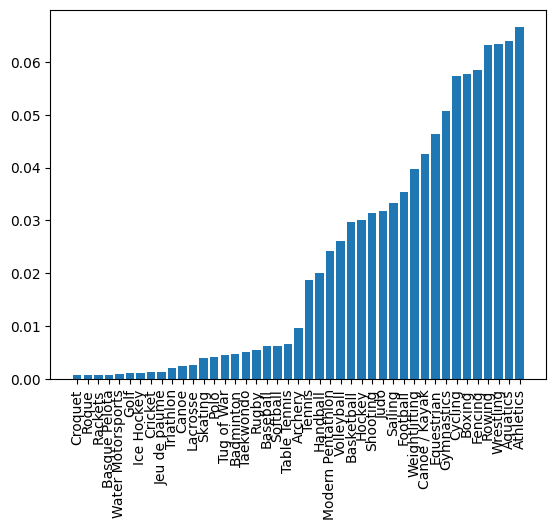

In [11]:
outputSorted = dict(sorted(output.items(), key=lambda item: item[1]))


plt.bar(outputSorted.keys(), outputSorted.values())
plt.xticks(rotation = 90)